# Libs

In [1]:

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import numpy as np

import os
import re
import sys

import seaborn as sns

import pickle
 
from collections import defaultdict
    
sys.path.append("/home/charles/Projects/BarycentersAgePyramid/Python")
sys.path.append("/home/dhw3172/projects/barycenterAgePyramid/Python")

from WassAge import *

from pathlib import Path

/home/charles/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Params

In [2]:
DATA_PATH = Path("." ) / ".." / ".." / "Data" 
os.listdir(DATA_PATH)

['Numpy',
 'shpLavalDAAgePyramid',
 'shpMtlDAAgePyramid',
 'shpHalifaxDAAgePyramid',
 'QuebecNeighbourhoods',
 '.ipynb_checkpoints',
 'MontrealNeighbourhoods',
 'shpCalgaryDAAgePyramid',
 'shpMontrealDAAgePyramid',
 'shpTorontoDAAgePyramid',
 'Extremal',
 'shpQuebecDAAgePyramid',
 'shpWinnipegDAAgePyramid',
 'shpVancouverDAAgePyramid',
 'shpWaterlooDAAgePyramid']

In [3]:
np.random.seed(1)

In [4]:
useApproxWass= False
approxStr = "Exact" if useApproxWass else "Approximate"

In [5]:
listCities =[ "Toronto","Waterloo","Vancouver","Winnipeg","Halifax","Calgary","Laval","Montreal","Quebec" ]
listShp=defaultdict(str)

In [6]:
len(listCities)

9

# Data IO

## Load back the city-wide wass barycenter + DA shp

In [7]:
maxY=-1
for c in listCities:
    try:
        shp=aggregateCleanDfGeo( readDAShp(city=c) )
        listShp[c]= shp
        maxY=max(maxY,  np.max(shp["Population"]))
    except Exception as e:
        print(f"Fatal error with city {c} - {str(e)}" )
        
    

Reading neibourhoods from Toronto
Reading neibourhoods from Waterloo
Reading neibourhoods from Vancouver
Reading neibourhoods from Winnipeg
Reading neibourhoods from Halifax
Reading neibourhoods from Calgary
Reading neibourhoods from Laval
Reading neibourhoods from Montreal
Reading neibourhoods from Quebec


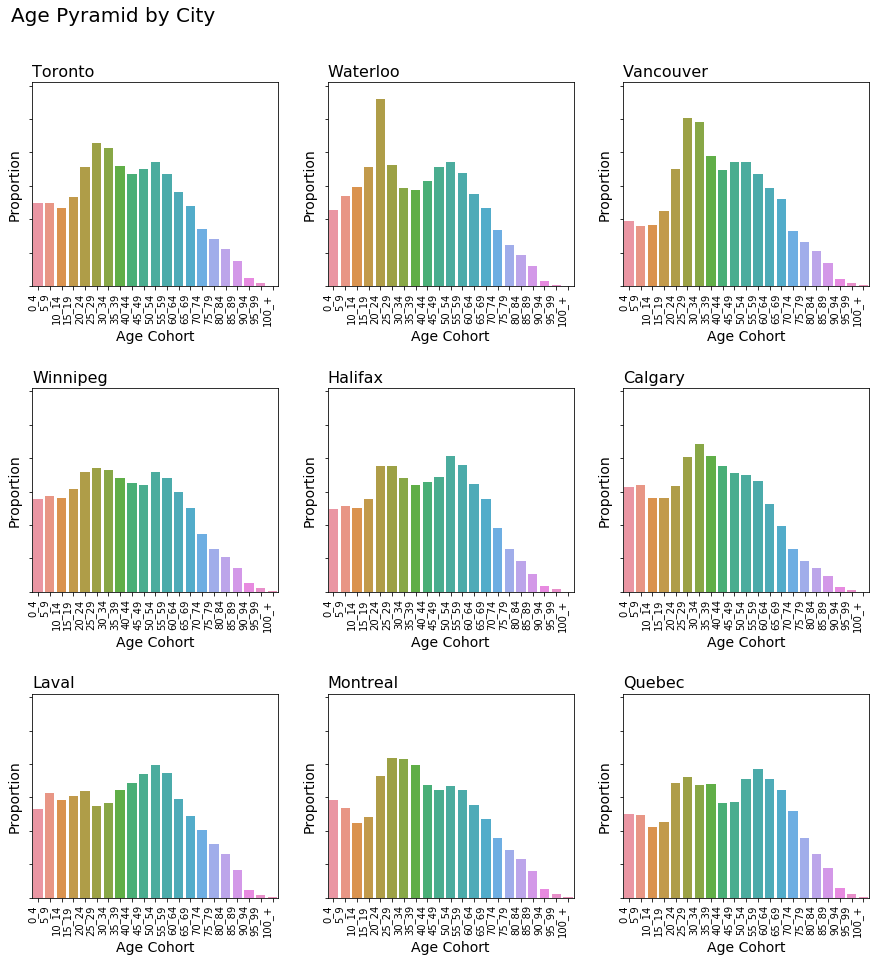

In [8]:
fig = plt.figure(figsize=(15,15))
 

for k,c in enumerate(listCities):

    sp=plt.subplot(3,3,k+1)
    
    dfGeo = listShp[c]
    
    ax = sns.barplot( x="index", y = "Population", data=dfGeo.reset_index()  )
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right', fontsize = 10)
    _ = ax.set_yticklabels(ax.get_yticklabels(),  fontsize = 12)
    plt.xlabel(ax.get_xticklabels(), fontsize=14)
    plt.ylabel(ax.get_yticklabels(), fontsize=14)
    ax.set(xlabel="Age Cohort", 
           ylabel="Proportion"
           )
    _= plt.title(label=f"{c}", loc="left",fontsize=16)
    plt.ylim(0,maxY+0.01)

    


#plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Age Pyramid by City\n\n",fontsize=20 , y=0.95, x=0.20)
 

fig.savefig( DATA_PATH /".."/ "Figures" / "ReferenceDistributions" / "agePyramidsFull9Cities.png")     

# Evaluate departure from reference uniform distribution with all weight at 1/n

In [12]:
def getAgeDist(ageArray):
    ageDist=np.ones_like(ageArray)/len(ageArray)
    
    return ageDist.ravel()

## Reference distribution: mass of 1/n

In [19]:
uniformDist=getAgeDist(getAgeRepresentativeArray() )
uniformDist.reshape(-1)

array([0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905, 0.04761905, 0.04761905, 0.04761905, 0.04761905,
       0.04761905])

## Distance matrix from age bin centroids

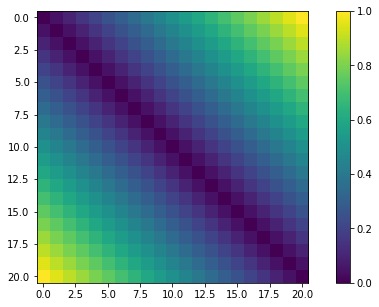

In [23]:
plt.figure(figsize=(10,5))
distMat = distance_matrix(getAgeRepresentativeArray(),getAgeRepresentativeArray())
distMat= distMat / np.max( distMat)
plt.imshow(distMat)
plt.colorbar()

In [26]:
listShp[c].values.reshape(-1).shape, uniformDist.shape

((21,), (21,))

## Compute EMD

In [27]:
dictOptTransport=defaultdict(str)
dictDist=defaultdict(str)

for k,c in enumerate(listCities):
    optT =ot.lp.emd( listShp[c].values.reshape(-1), uniformDist  ,distMat)
    
    dictOptTransport[c] = optT
    dictDist[c] = np.sum( optT[:] * distMat[:])

In [28]:
#Build the labels

In [29]:
np.linspace(0,21,num=int(21/2))
listIndex=[i for i in range(21) if i % int(21/7) == 0]
listIndex
listAgeSubset = np.array(LIST_AGE_COLS)[listIndex]
listAgeSubset, len(listAgeSubset)

(array(['0_4', '15_19', '30_34', '45_49', '60_64', '75_79', '90_94'],
       dtype='<U5'), 7)

In [30]:
listIndex=[ int( np.quantile(range(len(LIST_AGE_COLS)), i/9)) for i in range(10) ]
listAgeSubset = np.array(LIST_AGE_COLS)[listIndex]
listAgeSubset, len(listAgeSubset), len(listIndex)

(array(['0_4', '10_14', '20_24', '30_34', '40_44', '55_59', '65_69',
        '75_79', '85_89', '100_+'], dtype='<U5'), 10, 10)

## Visualize optimal transport 

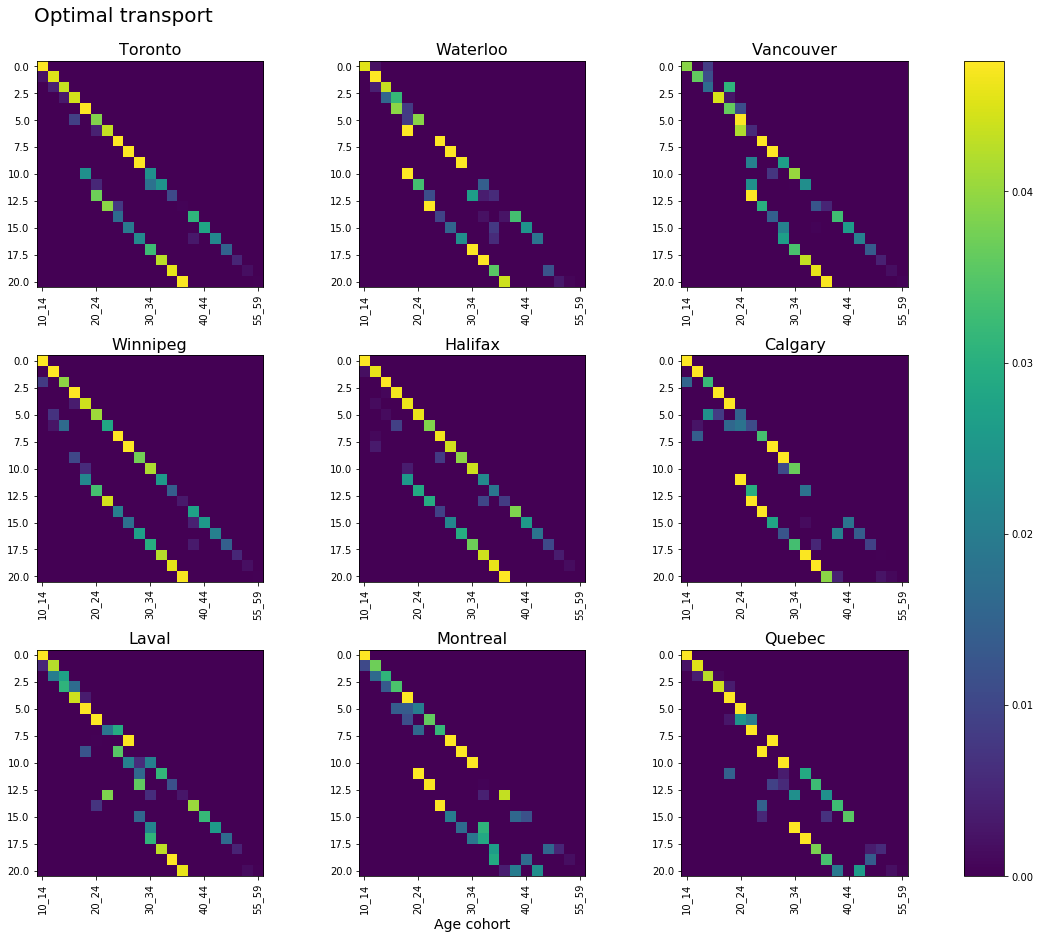

In [40]:
fig=plt.figure(figsize=(20,15))
listAxes=[]

gs1 = gridspec.GridSpec(3,3)
gs1.update(wspace=0.3, hspace=0.30) # set the spacing between axes. 


for k,n in enumerate(listCities):
    
    ax=plt.subplot(gs1[k]) 
    listAxes.append(ax)
    plt.imshow( dictOptTransport[n].T )
    ax.set_title(f"{n}", fontsize=16)
    plt.xticks(rotation=90)
    ax.set_xticklabels(labels=listAgeSubset)
    if n =="Montreal":
        ax.set_xlabel("Age cohort", fontsize=14)
 
                 
fig.suptitle("Optimal transport",fontsize=20,x=0.2, y=0.93)
plt.colorbar(ax=listAxes)

#plt.tight_layout(h_pad=2)

fig.savefig( Path(DATA_PATH) /".."/ "Figures" / "ReferenceDistributions"  / f"wassOptTransFromUnequalDistAll9.png")

## Compare cost


In [33]:
dfDist=pd.DataFrame.from_dict(dictDist, columns=['distance'] , orient='index').reset_index()
dfDist.rename(columns={"index":"city"},inplace=True)
dfDist.sort_values(by=["distance"],inplace=True)
dfDist.reset_index(inplace=True)

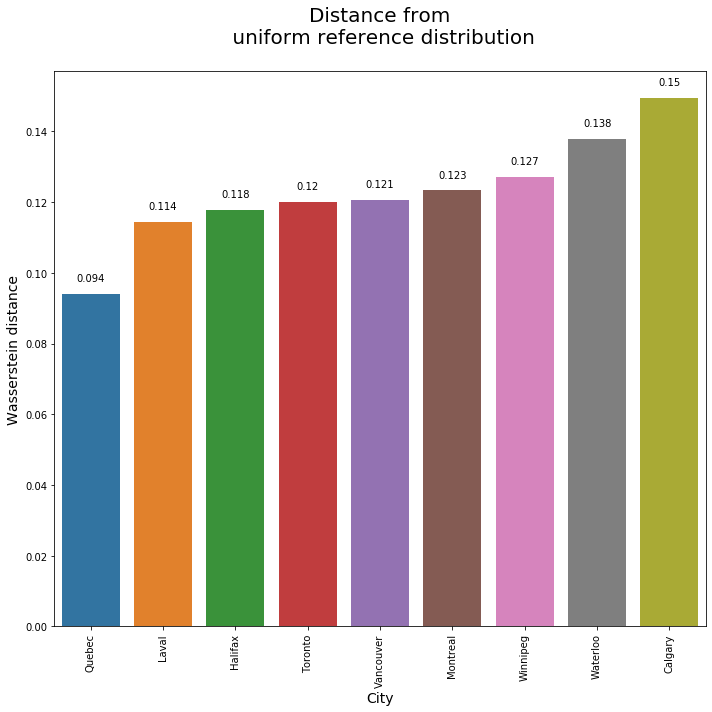

In [37]:
fig = plt.figure(figsize=(10,10))

ax = sns.barplot(x="city", y="distance"  ,data=dfDist)
ax.set_title("Distance from\n uniform reference distribution\n", fontsize=20)
ax.set_xlabel('City',fontsize=14);
ax.set_ylabel('Wasserstein distance',fontsize=14);
plt.xticks(rotation=90)

#iterrows loops according to the index => make sure it is sorted in the right order
for index, row in dfDist.iterrows():
   ax.text(row.name, row.distance+0.0036, round(row.distance,3), color='black', ha="center")

plt.tight_layout(rect=[0, 0, 1, 1])

fig.savefig( Path(DATA_PATH) /".."/ "Figures" / "ReferenceDistributions"  / f"wassDistFromUnequalDistAll9.png")